# Identifying bying clients

In this notebook we will create a decision tree based model to identify clients who pay (buyers) and understand what makes a user a client (most relevant features).

We divide our notebook into four stages: data preparation, feature engineering, model building, feature importance analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from IPython.display import display
import yaml


## 1. Data preparation

In this step we load from database (PostgreSQL in this example) data and keep it locally as a CSV file. '
The main reason for that is to be able to reproduce results quickly.

In [2]:
# Create a connection to the database

# Load a config file with credentials
conf = yaml.load(
    open("credentials.yml"), Loader=yaml.FullLoader)['pg']
# Create a connection
conn = psycopg2.connect(
    host=conf['host'],
    port=conf['port'],
    database=conf['database'],
    user=conf['user'],
    password=conf['password']
)

Here we prepare two functions to obtain data from the databases (or .csv files if they were pre-downloaded)

In [3]:
def load_events(source='csv') -> pd.DataFrame:
    """ Obtains session events from database or csv file"""
    if source == 'db':
        q = f'select * from connector_events where sessionid IN {sessions}'
        all_events = pd.read_sql(q, conn)
        all_events.to_csv('all_events_1454.csv', index=False)
    elif source == 'csv':
        all_events = pd.read_csv('all_events_1454_sep.csv', sep='|')
    else:
        raise ValueError("source parameter should be either 'csv' or 'db'")
    return all_events

def load_sessions(source='csv') -> pd.DataFrame:
    """ Obtains sessions information from database or csv file"""
    if source == 'db':
        q = f"select * from connector_user_sessions where sessionid in {sessions}"
        all_sessions = pd.read_sql(q, conn)
        # Saving as a CSV file is optional
        all_sessions.to_csv("all_sessions.csv", sep='|', index=False)
    elif source == 'csv':
        all_sessions = pd.read_csv("all_sessions.csv", sep='|')
    else:
        raise ValueError("source parameter should be either 'csv' or 'db'")
    return all_sessions


In the connector's events table we found a client who had a button with a label "PAY" by performing a simple query

`q = "select session_id from connector_events where mouseclick_label = 'PAY";`

We went on to find all session ids of this client from our internal tables and saved it in `all_sessions_1454.csv`.
This step is unnecessary for clients and only explained for general clarity.
**The most important takeaway here, is that we have prepared a list of sessions for which we know
whether a click on "PAY" button has been made or not.**

In [4]:
sessions_info = pd.read_csv("all_sessions_1454.csv")
sessions = tuple(sessions_info['session_id'])

First off, let's see that the dataset is highly imbalanced, because the number of buyers is much less than the number of ordinary visitors.
In fact, the percentage of buying clients (0.04%) is so small, it's not event seen on the pie chart.
Hence we're going to use special techniques for imbalanced datasets.

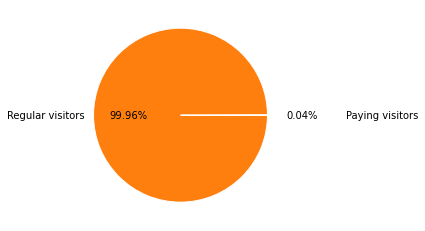

In [5]:
buyers_count = sessions_info[sessions_info.paid == 1].shape[0]
regular_count = sessions_info.shape[0] - buyers_count
ax = plt.subplot(111)
wedges, texts, _ = ax.pie(x=(buyers_count, regular_count),
        shadow=False,
        labels=['Paying visitors', 'Regular visitors'],
        autopct='%1.2f%%',
        explode=(0, 0.8))

for w in wedges:
    w.set_linewidth(1)
    w.set_edgecolor('white')

plt.show()


In [6]:
all_events = load_events()

c:\users\david\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (9,11,12,13,26) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Let's take a look at the events dataset by printing one session

In [7]:
all_events[all_events.sessionid == all_events.iloc[0].sessionid].head(10)

,sessionid,connectioninformation_downlink,connectioninformation_type,consolelog_level,consolelog_value,customevent_messageid,customevent_name,customevent_payload,customevent_timestamp,errorevent_message,...,issueevent_messageid,issueevent_timestamp,issueevent_type,issueevent_contextstring,issueevent_context,issueevent_payload,customissue_name,customissue_payload,received_at,batch_order_number
0,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.680858e+09,1.614202e+12,click_rage,SIGN OUT Triston Armstrong DEVELOPER Join GitS...,NaN,NaN,NaN,NaN,1616761976450,2962
2,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.680913e+09,1.614202e+12,click_rage,SAVE & NEXT,NaN,NaN,NaN,NaN,1616761976855,3003
3,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616761976460,2965
4,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.680859e+09,1.614202e+12,click_rage,SIGN OUT Triston Armstrong DEVELOPER Join GitS...,NaN,NaN,NaN,NaN,1616761976460,2966
5,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616761976464,2968
6,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1616761976539,2972
7,4207534060820504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.680898e+09,1.614202e+12,cpu,https://app.gitstart.com/,NaN,"{""Duration"":10581,""Rate"":94}",NaN,NaN,1616761976661,2988


We mostly see NaNs and that's OK.
One row in session events files contains user's actions grouped by timestamp.
For example, if there was a mouse click event at a time $t$, only the columns corresponding to that click
(such as mouseclick_label, mouseclick_hesitationtime etc) will be filled and the rest will be NaNs.
The columns sessionid, received_at, batch_order_number will always be filled as the contain information about the
session unique identifier, the time at which the event was received by connectors worker and the order number
to ensure the chronological ordering is preserved when inserting in database in batches.

In [8]:
# Let's take a glance at all available features
list(all_events.columns)


['sessionid',
 'connectioninformation_downlink',
 'connectioninformation_type',
 'consolelog_level',
 'consolelog_value',
 'customevent_messageid',
 'customevent_name',
 'customevent_payload',
 'customevent_timestamp',
 'errorevent_message',
 'errorevent_messageid',
 'errorevent_name',
 'errorevent_payload',
 'errorevent_source',
 'errorevent_timestamp',
 'jsexception_message',
 'jsexception_name',
 'jsexception_payload',
 'metadata_key',
 'metadata_value',
 'mouseclick_id',
 'mouseclick_hesitationtime',
 'mouseclick_label',
 'pageevent_firstcontentfulpaint',
 'pageevent_firstpaint',
 'pageevent_messageid',
 'pageevent_referrer',
 'pageevent_speedindex',
 'pageevent_timestamp',
 'pageevent_url',
 'pagerendertiming_timetointeractive',
 'pagerendertiming_visuallycomplete',
 'rawcustomevent_name',
 'rawcustomevent_payload',
 'setviewportsize_height',
 'setviewportsize_width',
 'timestamp_timestamp',
 'user_anonymous_id',
 'user_id',
 'issueevent_messageid',
 'issueevent_timestamp',
 'issu

## 2. Feature engineering

How are we going to predict buying users?
What kind of features identify them?

- Did the user visit the website earlier?
- Was the website not illustrating images?
- Did users experience many issues on the website?
- What pages did he visit?

All of those questions sound important.
In these section we will extract the answers to this questions from the datasets of events and sessions for each user.
We'll create a vector of numerical features and assign them to each user who visited the site.
Our goal is to see if the feature sets or buyers and  is separable by some nonlinear function with a good precision. We'll be looking for this function using decision trees model.
Of course one can experiment further by applying any other algorithm.

Unfortunately, none of the paying clients received ids.
Hence we'll only be looking into the session features.

In [9]:
# Create a DataFrame for session features
labels = sessions_info['paid']
session_features = sessions_info.drop(['paid'], axis=1)
session_features.rename({'session_id': 'sessionid'}, axis=1, inplace=True)

Let's get to some meaningful features. For example, let's create a function
that will tell if a specific event happened during the session.

In [10]:
def add_feature_about_event_presence(session_features, column, feature_name, dtype='int'):
    temp_sessions = all_events[['sessionid', column]].dropna()
    temp_sessions = temp_sessions.drop_duplicates(subset='sessionid', keep='last')
    if temp_sessions.shape[0] == 0:
        return session_features
    session_features = session_features.merge(temp_sessions, how='left', on='sessionid')

    if dtype == 'int':
        session_features.loc[session_features[column] > 0, feature_name] = 1
    elif dtype == 'str':
        session_features.loc[session_features[column] != '', feature_name] = 1
    session_features[feature_name] = session_features[feature_name].fillna(0)
    session_features = session_features.drop([column], axis=1)
    return session_features

In [11]:
for column, feature_name in [('errorevent_messageid', 'error_event'),
                             ('customevent_messageid', 'custom_event'),
                             ('jsexception_message', 'js_exception'),
                             ('customissue_name', 'custom_issue')
                             ]:
    session_features = add_feature_about_event_presence(session_features, column, feature_name)


At some point it's interesting to take a look
at the maximum values of some parameters during the session.
These features can be added with the function below:

In [12]:
def add_max_val(session_features, column):
    feature_df = all_events[['sessionid', column]].dropna()
    feature_df_agg = feature_df.groupby('sessionid').agg('max').reset_index()
    if feature_df_agg.shape[0] > 0:
        session_features = session_features.merge(feature_df_agg, how='left', on='sessionid')
        session_features[col] = session_features[col].fillna(0)
    return session_features

In [13]:
max_feature_columns = ['pageevent_firstcontentfulpaint',
                       'pageevent_firstpaint',
                       'pageevent_speedindex',
                       'pagerendertiming_timetointeractive',
                       'pagerendertiming_visuallycomplete',
                       'rawcustomevent_name',
                       'rawcustomevent_payload',
                       'setviewportsize_height',
                       'setviewportsize_width']

for col in max_feature_columns:
    session_features = add_max_val(session_features, col)



We also should handle categorical variables, the ones that can take on one of a limited,
and usually fixed, number of possible values (such us user's browser).

In [14]:
def add_categorial_feature(session_features, column, feature_name):
    categories = list(session_features[column].unique())
    session_features[feature_name] = pd.Categorical(session_features[column], categories=categories).codes

In [15]:
# Get additional information from sessions table
sessions_table = load_sessions()

c:\users\david\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (1,2,3,4,5,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [16]:
sessions_table = sessions_table.drop_duplicates(subset=['sessionid'], keep='last')
print(sessions_table.shape[0])

54057


In [17]:
for iss in ['click_rage', 'missing_resource', 'dead_click', 'js_exception', 'bad_request',  'cpu', 'memory']:
    session_features[iss] = session_features['issue_types'].apply(lambda x: 1 if iss in x else 0)
session_features = session_features.drop(['issue_types'], axis=1)

In [18]:
session_features.head(10)

,sessionid,events_count,pages_count,error_event,pageevent_firstcontentfulpaint,pageevent_firstpaint,pageevent_speedindex,pagerendertiming_timetointeractive,pagerendertiming_visuallycomplete,setviewportsize_height,setviewportsize_width,click_rage,missing_resource,dead_click,js_exception,bad_request,cpu,memory
0,4323603410944837,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,4323604627948361,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
2,4323603204776517,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0
3,4323548146402182,37,7,0.0,3940.0,3850.0,3825.0,0.0,0.0,0.0,0.0,1,1,0,0,0,1,0
4,4323554393301661,10,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
5,4323594072990251,17,5,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0
6,4323655897228014,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
7,4323630712718240,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
8,4323592422793765,11,1,0.0,2312.0,2251.0,2312.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0
9,4323618781102971,7,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [19]:
session_features.shape

(57794, 18)

In [20]:
def add_one_hot_encoded_feature(origin_df, session_features, column):
    df = origin_df[['sessionid', column]]
    dummies = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    df = pd.concat([df, dummies], axis=1)
    session_features = session_features.merge(df, how='left', on='sessionid')
    session_features = session_features.drop([column], axis=1)
    return session_features

In [21]:
for col in ['user_browser', 'user_country', 'user_device', 'connection_type']:
    session_features = add_one_hot_encoded_feature(sessions_table, session_features, col)

In [22]:
session_features.shape

(57794, 34)

In [23]:
columns_to_merge = ['connection_effective_bandwidth', 'session_start_timestamp',
                    'session_duration', 'user_device_heap_size',
                    'user_device_memory_size', 'avg_cpu', 'avg_fps',  'max_cpu',
                    'max_fps', 'max_total_js_heap_size', 'max_used_js_heap_size',
                    'js_exceptions_count', 'long_tasks_total_duration', 'long_tasks_max_duration',
                    'long_tasks_count', 'inputs_count', 'clicks_count', 'sessionid'
                    ]
session_features = session_features.merge(sessions_table[columns_to_merge],
                                          how='left',
                                          on='sessionid')

In [24]:
session_features = session_features.dropna(how='all', axis=0)
session_features = session_features.fillna(0)
session_features.head()


,sessionid,events_count,pages_count,error_event,pageevent_firstcontentfulpaint,pageevent_firstpaint,pageevent_speedindex,pagerendertiming_timetointeractive,pagerendertiming_visuallycomplete,setviewportsize_height,...,max_cpu,max_fps,max_total_js_heap_size,max_used_js_heap_size,js_exceptions_count,long_tasks_total_duration,long_tasks_max_duration,long_tasks_count,inputs_count,clicks_count
0,4323603410944837,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,120.0,51399294.0,46629158.0,0.0,9161.0,68.0,7.0,0.0,0.0
1,4323604627948361,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4323603204776517,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,190.0,49323074.0,47140794.0,0.0,407.0,73.0,3.0,1.0,0.0
3,4323548146402182,37,7,0.0,3940.0,3850.0,3825.0,0.0,0.0,0.0,...,68.0,60.0,140152925.0,121761837.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4323554393301661,10,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,61.0,86162824.0,82145777.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
session_features.shape

(57794, 51)

## 3. Build model

Decision tree model is chosen because it is known to work great with heterogenous datasets and correlated features

In [26]:
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(session_features.drop(['sessionid'], axis=1),
                                                    labels,
                                                    test_size=0.15,
                                                    random_state=42)


In [28]:
# Ensure that test set has paying clients
sum(y_test), sum(y_train)

(6, 17)

In [29]:
# Ratio of paying sessions will be denoted by EPSILON
EPSILON = y_train[y_train == 1].shape[0]/y_train.shape[0]
EPSILON

0.0003460630241836984

In [30]:
xgc0 = xgb.XGBClassifier()
xgc0.fit(x_train, y_train)

c:\users\david\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
xgc = xgb.XGBClassifier(scale_pos_weight=1/EPSILON)
xgc.fit(x_train, y_train)


[17:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2889.6470588235293,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

## 4. Evaluate and choose the best model

In this section we will built two models
and see at their performances using different metrics

In [32]:
from datetime import datetime
from xgboost import plot_importance
from sklearn.metrics import plot_roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve


In [33]:
def report(models, x_test, y_test, y_pred=None, model_names=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

    for model, name in zip(models, model_names):

        y_out = model.predict(x_test)

        precision = precision_score(y_test, y_out)
        recall = recall_score(y_test, y_out)
        accuracy = accuracy_score(y_test, y_out)

        print(f'Model: {name}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'Accuracy: {accuracy}')
        print('-------------------------')
        print()

        roc_auc = plot_roc_curve(model, x_test, y_test, ax=ax1)
        precision_recall = plot_precision_recall_curve(model, x_test, y_test, ax=ax2)

    date_time = datetime.now().strftime("%m_%d_%H_%M_%S")
    plt.savefig(f'report_{date_time}.png', dpi=300)
    plt.show()


Model: XGBClassifier
Precision: 0.8
Recall: 0.6666666666666666
Accuracy: 0.9996539792387543
-------------------------

Model: Weighted XGBClassifier
Precision: 0.6666666666666666
Recall: 1.0
Accuracy: 0.9996539792387543
-------------------------



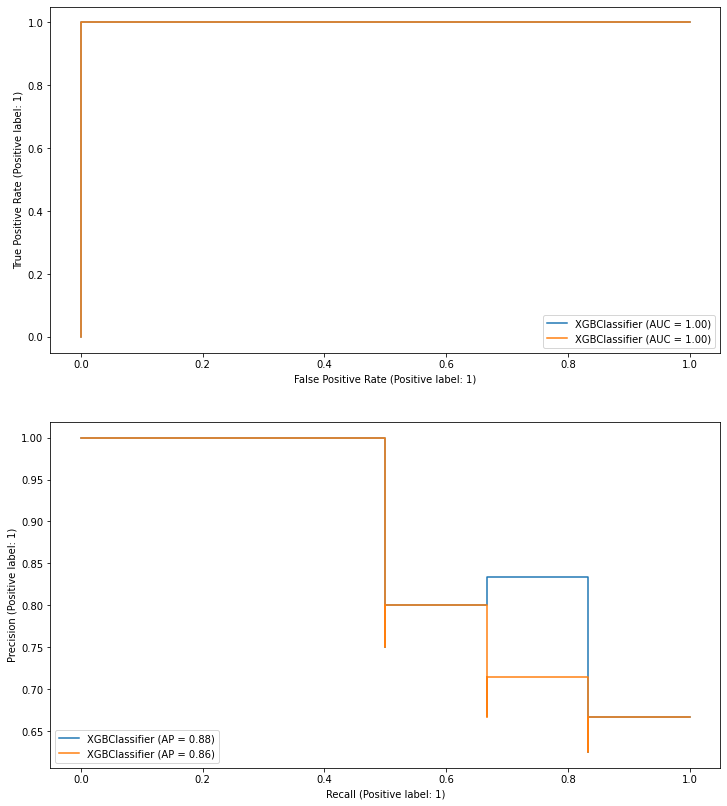

In [34]:
report([xgc0, xgc], x_test, y_test, model_names=['XGBClassifier', 'Weighted XGBClassifier'])

For the best model let's see the features that influenced the decision the most:


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

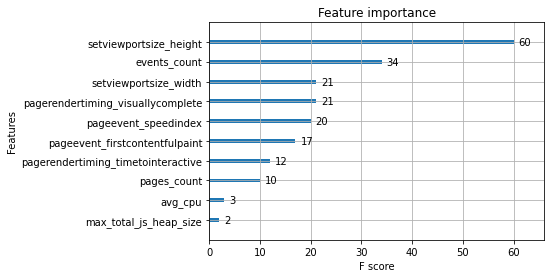

In [35]:
plot_importance(xgc0)